In [1]:
!pip3 install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 9.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
import torch
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
import numpy as np
from datasets import load_metric
from transformers import TrainingArguments, Trainer
import pandas as pd

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyarrow as pa
from datasets import Dataset
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from sklearn.utils import shuffle
from datasets import Dataset, Value, ClassLabel, Features

In [4]:
torch.cuda.is_available()

True

**Download From Kaggle Dataset**

In [5]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"<username>","key":"<key>"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json
     

In [6]:
!kaggle datasets download -d kazanova/sentiment140

 99% 80.0M/80.9M [00:04<00:00, 22.1MB/s]
100% 80.9M/80.9M [00:04<00:00, 18.5MB/s]


In [7]:
!unzip sentiment140

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


**Load the dataset**

In [8]:
df  = pd.read_csv("/content/training.1600000.processed.noemoticon.csv",encoding='latin-1')
df.columns =['label','timestamp','date','query','username','text']
df.head()

,label,timestamp,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


**Remove the unwanted columns**

In [9]:
df = df.drop(columns=['timestamp','date','query','username'])
df.head()

,label,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


**Shuffle the dataframe**
label  (0 = negative, 2 = neutral, 4 = positive)

In [10]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head()

,label,text
65162,0,Homework http://myloc.me/sUN
961922,4,@rhea123 i will later.
1314811,4,shares http://kingreyes.wordpress.com/ (My Sou...
1427369,4,Finally finished with my 10 hour day. I &lt;3 ...
239555,0,it ruined the fiesta we had in our village thi...


**Remove links starting with https and http and also the tagging which starts wih @. Example @user**

In [35]:
def clean_tagging(X):
    X = X.split()
    X_new = [x for x in X if not x.startswith("@")]
    return ' '.join(X_new)

def clean_https(X):
    X = X.split()
    X_new = [x for x in X if not x.startswith("https")]
    return ' '.join(X_new)

def clean_http(X):
    X = X.split()
    X_new = [x for x in X if not x.startswith("http")]
    return ' '.join(X_new)

df['text'] = df['text'].apply(clean_tagging)
df['text'] = df['text'].apply(clean_https)
df['text'] = df['text'].apply(clean_http)
df.head()

,label,text
65162,0,Homework
961922,4,i will later.
1314811,4,shares (My Soulja Boy Vlog! Vlog # 2! Check it...
1427369,4,Finally finished with my 10 hour day. I &lt;3 ...
239555,0,it ruined the fiesta we had in our village thi...


**Split train and test**

90 % for test and 10 % for test


In [12]:
length = int(0.90*len(df))
df_train = df[0:length]
df_test = df[length:len(df)]

In [13]:
print(len(df_train))
print(len(df_test))

1439999
160000


**Get polarity scores ratio in the train data**

In [14]:
df_train['label'].value_counts()

0    720015
4    719984
Name: label, dtype: int64

In [15]:
df_test['label'].value_counts()

4    80016
0    79984
Name: label, dtype: int64

**Get Word cloud with respect to the data for polarity = 4 which stands for postivie**

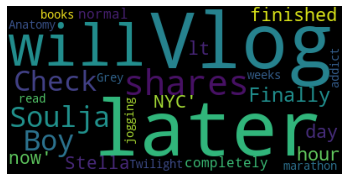

In [16]:
positive =  df_train.loc[df_train['label'] == 4]
text = positive['text'].values 
wordcloud = WordCloud().generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**Get Word cloud with respect to the data for polarity = 0 which stands for negative**

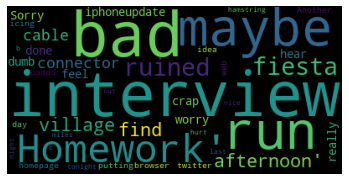

In [17]:
negative =  df_train.loc[df_train['label'] == 0]
text = negative['text'].values 
wordcloud = WordCloud().generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**Loading the tokenizer**

In [18]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

**Load the train df to Arrow dataset**

Refer : https://huggingface.co/docs/datasets/v1.0.2/loading_datasets.html


* sampling the df_train to 80000 (Just to train the model quicker)
*   removing none values from the df
*   reset the index and remove the index from the df
*   Convert the df to arrow dataset
*   Change the feature of the dataset

The tokenized_text must have form of


**(0 = negative 4 = positive)**


```
{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['0','4'], id=None)}
```







In [19]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True,padding=True)

In [20]:
df_train = df_train[:80000]
df_train =  df_train.dropna()
df_train.reset_index(drop=True, inplace=True)

# df_train to arrow dataset
dataset = Dataset.from_pandas(df_train)
print(dataset.features)

# change the feature of the dataset
features = dataset.features.copy()
# 0 stand for negative and 1 stands for positive
features["label"] = ClassLabel(num_classes=2, names=['0','4'])
def adjust_labels(batch):
    batch["label"] = [str(sentiment) for sentiment in batch["label"]]
    return batch
dataset = dataset.map(adjust_labels, batched=True, features=features)

print(dataset.features)
tokenized_train = dataset.map(preprocess_function, batched=True)

{'label': Value(dtype='int64', id=None), 'text': Value(dtype='string', id=None)}


  0%|          | 0/80 [00:00<?, ?ba/s]

{'label': ClassLabel(names=['0', '4'], id=None), 'text': Value(dtype='string', id=None)}


  0%|          | 0/80 [00:00<?, ?ba/s]

In [21]:
tokenized_train.features

{'label': ClassLabel(names=['0', '4'], id=None),
 'text': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

**Trimming test data to 10000**

In [22]:
df_test = df_test[:10000]
df_test =  df_test.dropna()
df_test.reset_index(drop=True, inplace=True)

# df_test to arrow dataset
dataset = Dataset.from_pandas(df_test)
print(dataset.features)

# change the feature of the dataset
features = dataset.features.copy()
# 0 stand for negative and 1 stands for positive
features["label"] = ClassLabel(num_classes=2,  names=['0','4'])
def adjust_labels(batch):
    batch["label"] = [str(sentiment) for sentiment in batch["label"]]
    return batch
dataset = dataset.map(adjust_labels, batched=True, features=features)

tokenized_test = dataset.map(preprocess_function, batched=True)

{'label': Value(dtype='int64', id=None), 'text': Value(dtype='string', id=None)}


  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [23]:
tokenized_test.features

{'label': ClassLabel(names=['0', '4'], id=None),
 'text': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

**To speed up training, let's use a data_collator to convert your training samples to PyTorch tensors and concatenate them with the correct amount of padding**

In [24]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# **Define a Model**

DistilBERT is a small, fast, cheap and light Transformer model based on the BERT architecture. 

Knowledge distillation is performed during the pre-training phase to reduce the size of a BERT model by 40%.

https://www.techtarget.com/searchenterpriseai/definition/BERT-language-model

distilbert-base-uncased

https://huggingface.co/distilbert-base-uncased



In [25]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

In [26]:

def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}


training_args = TrainingArguments(
   output_dir="/content/model/",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=False,
)
 

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
     

In [27]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 80000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 10000
  Number of trainable parameters = 66955010
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster

Step,Training Loss
500,0.495600
1000,0.418300
1500,0.423800
2000,0.402300
2500,0.393600
3000,0.388200
3500,0.410700
4000,0.394000
4500,0.380100
5000,0.374000


Saving model checkpoint to /content/model/checkpoint-5000
Configuration saved in /content/model/checkpoint-5000/config.json
Model weights saved in /content/model/checkpoint-5000/pytorch_model.bin
tokenizer config file saved in /content/model/checkpoint-5000/tokenizer_config.json
Special tokens file saved in /content/model/checkpoint-5000/special_tokens_map.json


Step,Training Loss
500,0.495600
1000,0.418300
1500,0.423800
2000,0.402300
2500,0.393600
3000,0.388200
3500,0.410700
4000,0.394000
4500,0.380100
5000,0.374000


Saving model checkpoint to /content/model/checkpoint-10000
Configuration saved in /content/model/checkpoint-10000/config.json
Model weights saved in /content/model/checkpoint-10000/pytorch_model.bin
tokenizer config file saved in /content/model/checkpoint-10000/tokenizer_config.json
Special tokens file saved in /content/model/checkpoint-10000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=10000, training_loss=0.3530756362915039, metrics={'train_runtime': 1848.97, 'train_samples_per_second': 86.535, 'train_steps_per_second': 5.408, 'total_flos': 5117037607014336.0, 'train_loss': 0.3530756362915039, 'epoch': 2.0})

In [30]:
trainer.evaluate(tokenized_train)

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 80000
  Batch size = 16


Step,Training Loss,Validation Loss,Accuracy,F1
366,No log,0.393177,0.837700,0.836342
366,No log,0.226634,0.912125,0.911443


{'eval_loss': 0.22663374245166779,
 'eval_accuracy': 0.912125,
 'eval_f1': 0.9114431119621084}

In [31]:
trainer.save_model("/content/trained_model/")

Saving model checkpoint to /content/trained_model/
Configuration saved in /content/trained_model/config.json
Model weights saved in /content/trained_model/pytorch_model.bin
tokenizer config file saved in /content/trained_model/tokenizer_config.json
Special tokens file saved in /content/trained_model/special_tokens_map.json


In [32]:
!zip -r trained.zip /content/trained_model/

  adding: content/trained_model/ (stored 0%)
  adding: content/trained_model/vocab.txt (deflated 53%)
  adding: content/trained_model/special_tokens_map.json (deflated 42%)
  adding: content/trained_model/pytorch_model.bin (deflated 8%)
  adding: content/trained_model/tokenizer_config.json (deflated 41%)
  adding: content/trained_model/tokenizer.json (deflated 71%)
  adding: content/trained_model/config.json (deflated 46%)
  adding: content/trained_model/training_args.bin (deflated 48%)


In [38]:
!cp trained.zip /content/drive/MyDrive/twitter/

In [39]:
from transformers import TextClassificationPipeline

model = AutoModelForSequenceClassification.from_pretrained("/content/trained_model/", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

loading configuration file /content/trained_model/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/trained_model/",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file /content/trained_model/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at /content/trained_model/.
If your t

In [62]:
test = df.tail(5)
texts = list(test["text"])
test

,label,text
1381041,4,okay now ur set
1414748,4,Hehe he forgot how old i am. I love that he is...
1051251,4,And so it begins.
954985,4,Yay nice day still in bed how
123468,0,Headache to slay a walrus


In [64]:
print(texts[1])
print(pipe(texts[1]))
# (0 = negative, 1= positive)

Hehe he forgot how old i am. I love that he is 9 years older.
[[{'label': 'LABEL_0', 'score': 0.008789301849901676}, {'label': 'LABEL_1', 'score': 0.9912106990814209}]]


In [65]:
print(texts[4])
print(pipe(texts[4]))
# (0 = negative, 1= positive)

Headache to slay a walrus
[[{'label': 'LABEL_0', 'score': 0.9922069907188416}, {'label': 'LABEL_1', 'score': 0.0077930474653840065}]]
